# Model B: Includes Everything

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_classif,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    make_scorer,
    r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import LinearSVC

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
set_config(display="diagram")
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 50, 'display.max_columns', None) 

mortgage = pd.read_csv('Input/mortgage_train.csv')

In [3]:
perc = 94.6 # Like N %
min_count =  int(((100-perc)/100)*mortgage.shape[0] + 1)
mortgage = mortgage.dropna( axis=1, 
                thresh=min_count)

In [4]:
#mortgage = mortgage[mortgage["action_taken"].str.contains("Team 1|Team 2") == False]

In [5]:
mortgage = mortgage[(mortgage.action_taken == 2) | (mortgage.action_taken == 3)]

In [6]:
#mortgage[(mortgage.action_taken != 1) & (mortgage.action_taken != 4) & (mortgage.action_taken != 4) & (mortgage.action_taken != 4)]

In [7]:
#mortgage.info()

In [8]:
#mortgage

In [9]:
#mortgage.loc[mortgage['action_taken'] == 3] # Application approved but not accepted

In [10]:
y = mortgage.action_taken== 3
y.value_counts()
mortgage = mortgage.drop("action_taken", axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(mortgage, y, stratify=y, test_size=0.2, random_state=0
)

In [11]:
numer_pipe = make_pipeline(SimpleImputer(),StandardScaler()) 

cat_pipe = make_pipeline(OneHotEncoder())


preproc_pipe = ColumnTransformer([("num_impute", numer_pipe, make_column_selector(dtype_include=np.number)),
                                  ("cat_trans", cat_pipe, ['loan_purpose_name'])],remainder = 'drop')

clf_logit = make_pipeline(preproc_pipe, LogisticRegression())

In [12]:
clf_logit.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb5e21b640>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['loan_purpose_name'])])),
                ('logisticregression', LogisticRegression())])

In [13]:
print(classification_report(y_train, 
                            clf_logit.predict(X_train)))

              precision    recall  f1-score   support

       False       0.67      0.01      0.01       267
        True       0.90      1.00      0.95      2296

    accuracy                           0.90      2563
   macro avg       0.78      0.50      0.48      2563
weighted avg       0.87      0.90      0.85      2563



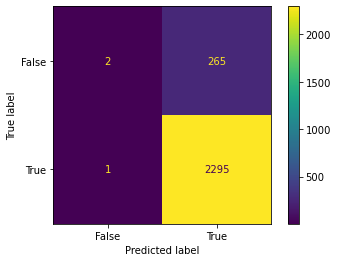

In [14]:
ConfusionMatrixDisplay.from_estimator(clf_logit, X_train, y_train)

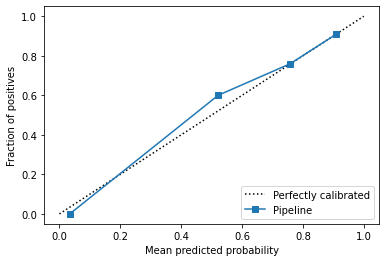

In [15]:
CalibrationDisplay.from_estimator(clf_logit, X_train, y_train)

In [16]:
logit_pred_test = pd.DataFrame({'Respondent_ID': X_test['respondent_id'], 'Prediction': clf_logit.predict(X_test)})
logit_pred_test
#when true, model predicted it they would deny and they did 

,Respondent_ID,Prediction
1488,66158,True
3495,705537,True
2022,26-4599244,True
2532,22-3747694,True
4749,1768800000,True
...,...,...
6481,817824,True
8576,280110,True
9943,47-0912342,True
9462,36-4771976,True


In [18]:
logit_pred_test.to_csv('pred/test1.csv', index=False)

In [24]:
bigmort = pd.read_csv('input/mortgage_holdout.csv')

In [25]:
perc = 94.6 # Like N %
min_count =  int(((100-perc)/100)*mortgage.shape[0] + 1)
bigmort = bigmort.dropna( axis=1, 
                thresh=min_count)

In [26]:
bigmort = bigmort[(bigmort.action_taken == 2) | (bigmort.action_taken == 3)]

In [27]:
bigtest = pd.DataFrame({'Respondent_ID': bigmort['respondent_id'], 'Prediction': clf_logit.predict(bigmort)})
bigtest
#fals, model rejects loan but in reality they accepted the loan

,Respondent_ID,Prediction
1,43-1965151,True
6,0000480228,True
12,0000817824,True
14,7197000003,True
16,0000675332,True
...,...,...
473749,0000451965,True
473752,26-2261031,True
473754,45-5510883,True
473755,0000002551,True


In [28]:
bigtest.to_csv('pred/test2.csv', index=False)

In [ ]:
#THIS DID NOT EXCLUDE DEMOGRAPHICS, need to find way to exclude numerical values that represent 
#race (we can still not use any of the categorical variables in our pipeline.)